### aim: lateral transports

`calculated in AMOC-PLANKTOM/lateral-transports.py`

### date: 

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [141]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time

plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)


Text(0.5, 0.98, 'ocean regions, subdivided, with atlantic mask (rh side modified for easier transports)')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


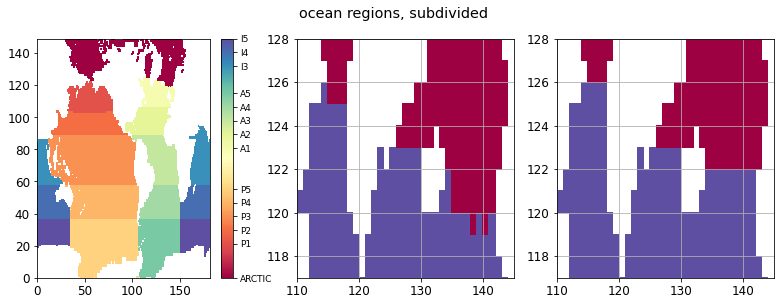

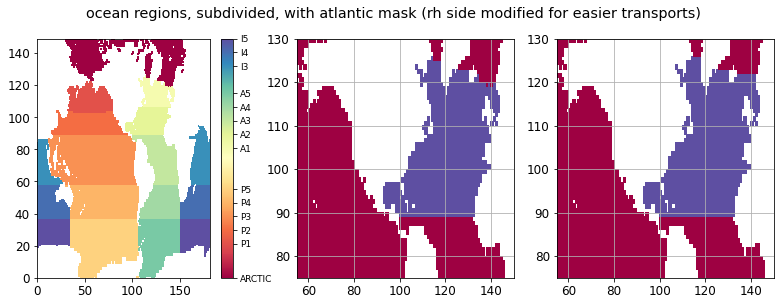

In [5]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan

masknoATL = np.copy(maskno)

masknoATL[np.where(masknoATL == 2.6) ]= 5
masknoATL[np.where(masknoATL == 2.4) ]= 5
masknoATL[masknoATL < 5] = 0

fact = 1.1
fig, axs = plt.subplots(1,3, figsize=(12*fact, 4*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

w = axs[0].pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
cbar = plt.colorbar(w, ticks=tics, ax = axs[0])
t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
plt.suptitle('ocean regions, subdivided')

w = axs[1].pcolor(masknoATL, cmap = tcm, vmin = 0.5, vmax = 4)

axs[1].set_xlim([55,150])
axs[1].set_ylim([75,130])
axs[1].set_xlim([110,145])
axs[1].set_ylim([117,128])
axs[1].grid()

###here is the transport boundary fix
masknoATLnb = np.copy(masknoATL)
masknoATLnb[118:122,130:144] = 5
masknoATLnb[125:126,110:120] = 5
nan_mask = np.isnan(masknoATL)
masknoATLnb[nan_mask] = np.nan
w = axs[2].pcolor(masknoATLnb, cmap = tcm, vmin = 0.5, vmax = 4)
axs[2].set_xlim([110,145])
axs[2].set_ylim([117,128])
axs[2].grid()

fact = 1.1
fig, axs = plt.subplots(1,3, figsize=(12*fact, 4*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

w = axs[0].pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
cbar = plt.colorbar(w, ticks=tics, ax = axs[0])
t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
plt.suptitle('ocean regions, subdivided')

w = axs[1].pcolor(masknoATL, cmap = tcm, vmin = 0.5, vmax = 4)

axs[1].set_xlim([55,150])
axs[1].set_ylim([75,130])
axs[1].grid()

w = axs[2].pcolor(masknoATLnb, cmap = tcm, vmin = 0.5, vmax = 4)
axs[2].set_xlim([55,150])
axs[2].set_ylim([75,130])
axs[2].grid()


#masknoATLnb[]
plt.suptitle('ocean regions, subdivided, with atlantic mask (rh side modified for easier transports)')



## identify borders for lateral transport: newfoundland-greenland (N1), greenland-iceland (N2), iceland-norway (N3) and the southern border (S1)

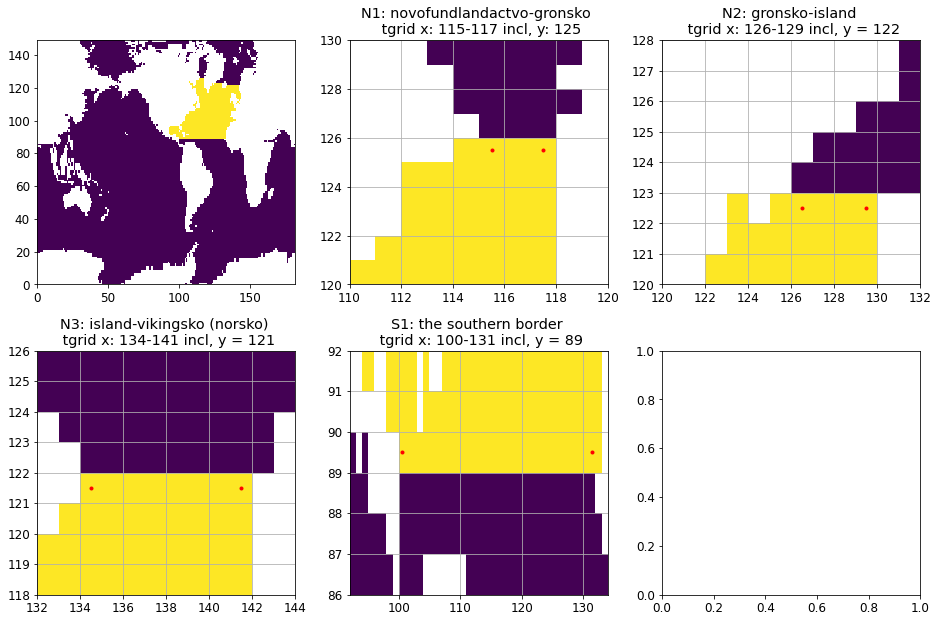

In [6]:
tm = masknoATLnb

fact = 1.1
fig, axs = plt.subplots(2,3, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].pcolormesh(tm)

axs[1].pcolormesh(tm)
axs[1].set_title('N1: novofundlandactvo-gronsko \n tgrid x: 115-117 incl, y: 125')
axs[1].pcolormesh(tm); axs[1].set_xlim([110,120]); axs[1].set_ylim([120,130])
axs[1].plot(115.5,125.5,'r.')
axs[1].plot(117.5,125.5,'r.')
#newfoundland boundary: x: 115,116,117 y:125

ind = 2
axs[ind].set_title('N2: gronsko-island \n tgrid x: 126-129 incl, y = 122')
axs[ind].pcolormesh(tm); axs[ind].set_xlim([120,132]); axs[ind].set_ylim([120,128])
axs[ind].plot(126.5,122.5,'r.');axs[ind].plot(129.5,122.5,'r.')
#gronsko boundary: x: 134-141 inclusive, y = 121

ind = 3
axs[ind].set_title('N3: island-vikingsko (norsko) \n tgrid x: 134-141 incl, y = 121')
axs[ind].pcolormesh(tm); axs[ind].set_xlim([132,144]); axs[ind].set_ylim([118,126])
axs[ind].plot(134.5,121.5,'r.');axs[ind].plot(141.5,121.5,'r.')
#gronsko boundary: x: 134-141 inclusive, y = 121

ind = 4
axs[ind].set_title('S1: the southern border \n tgrid x: 100-131 incl, y = 89')
axs[ind].pcolormesh(tm); axs[ind].set_xlim([92,134]); axs[ind].set_ylim([86,92])
axs[ind].plot(100.5,89.5,'r.');axs[ind].plot(131.5,89.5,'r.')

#gronsko boundary: x: 134-141 inclusive, y = 121


for i in range(1,5):
    
    axs[i].grid()
    
plt.tight_layout()

we now want transport across each of these boundaries. the v grid and the t grid are offset, so let's look at that:

In [8]:
N1_x1 = 115; N1_x2 = 117; N1_y = 125
N2_x1 = 126; N2_x2 = 129; N2_y = 122
N3_x1 = 134; N3_x2 = 141; N3_y = 121
S1_x1 = 100; S1_x2 = 131; S1_y = 89


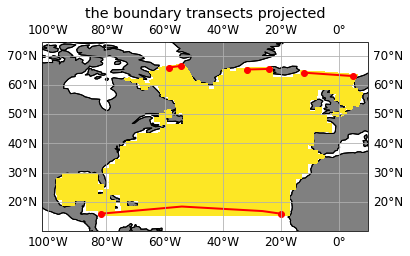

In [9]:

fact = 0.8
tfig = plt.figure(figsize=[10.5*fact, 14.5*fact])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(zorder = 0 )
#lons, lats extent
ax.set_extent([ -102, 10, 10, 75,], crs=ccrs.PlateCarree())

nav_lon = tgrid['nav_lon'].values
nav_lat = tgrid['nav_lat'].values
tm2 = np.copy(tm)
tm2[tm == 0] = np.nan
mesh = ax.pcolormesh(nav_lon, nav_lat, tm2, transform=ccrs.PlateCarree(), cmap='viridis_r')
#plt.colorbar(mesh, orientation = 'horizontal', label = 'rho')
ax.add_feature(cp.feature.LAND, color='grey')

N1start_lat, N1start_lon = nav_lat[N1_y, N1_x1], nav_lon[N1_y, N1_x1]
N1end_lat, N1end_lon = nav_lat[N1_y, N1_x2], nav_lon[N1_y, N1_x2]
ax.plot([N1start_lon, N1end_lon], [N1start_lat, N1end_lat], color='red', \
        linewidth=2, marker='o', transform=ccrs.Geodetic())


N2start_lat, N2start_lon = nav_lat[122, 126], nav_lon[122, 126]
N2end_lat, N2end_lon = nav_lat[122, 129], nav_lon[122, 129]
ax.plot([N2start_lon, N2end_lon], [N2start_lat, N2end_lat], color='red', \
        linewidth=2, marker='o', transform=ccrs.Geodetic())

N3start_lat, N3start_lon = nav_lat[121, 134], nav_lon[121, 134]
N3end_lat, N3end_lon = nav_lat[121, 141], nav_lon[121, 141]
ax.plot([N3start_lon, N3end_lon], [N3start_lat, N3end_lat], color='red', \
        linewidth=2, marker='o', transform=ccrs.Geodetic())

S1start_lat, S1start_lon = nav_lat[89, 100], nav_lon[89, 100]
S1end_lat, S1end_lon = nav_lat[89, 131], nav_lon[89, 131]
ax.plot([S1start_lon, S1end_lon], [S1start_lat, S1end_lat], color='red', \
        linewidth=2, marker='o', transform=ccrs.Geodetic())

ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.coastlines(zorder = 0 )
plt.title('the boundary transects projected')
plt.tight_layout()
plt.show()

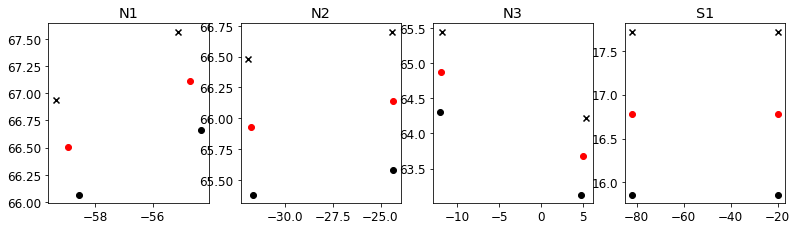

In [27]:



fact = 1.1
fig, axs = plt.subplots(1,4, figsize=(12*fact, 3*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

#axs[0].pcolormesh(tm)
# for i in range(0,3):
axs[0].scatter(vgrid['nav_lon'][N1_y,N1_x1],vgrid['nav_lat'][N1_y,N1_x1],marker = 'o', color = 'r')
axs[0].scatter(tgrid['nav_lon'][N1_y,N1_x1],tgrid['nav_lat'][N1_y,N1_x1],marker = 'o', color = 'k')
axs[0].scatter(tgrid['nav_lon'][N1_y+1,N1_x1],tgrid['nav_lat'][N1_y+1,N1_x1],marker = 'x', color = 'k', label = 'y+1')
axs[0].scatter(vgrid['nav_lon'][N1_y,N1_x2],vgrid['nav_lat'][N1_y,N1_x2],marker = 'o', color = 'r')
axs[0].scatter(tgrid['nav_lon'][N1_y,N1_x2],tgrid['nav_lat'][N1_y,N1_x2],marker = 'o', color = 'k')
axs[0].scatter(tgrid['nav_lon'][N1_y+1,N1_x2],tgrid['nav_lat'][N1_y+1,N1_x2],marker = 'x', color = 'k', label = 'y+1')

axs[1].scatter(vgrid['nav_lon'][N2_y,N2_x1],vgrid['nav_lat'][N2_y,N2_x1],marker = 'o', color = 'r')
axs[1].scatter(tgrid['nav_lon'][N2_y,N2_x1],tgrid['nav_lat'][N2_y,N2_x1],marker = 'o', color = 'k')
axs[1].scatter(tgrid['nav_lon'][N2_y+1,N2_x1],tgrid['nav_lat'][N2_y+1,N2_x1],marker = 'x', color = 'k', label = 'y+1')
axs[1].scatter(vgrid['nav_lon'][N2_y,N2_x2],vgrid['nav_lat'][N2_y,N2_x2],marker = 'o', color = 'r')
axs[1].scatter(tgrid['nav_lon'][N2_y,N2_x2],tgrid['nav_lat'][N2_y,N2_x2],marker = 'o', color = 'k')
axs[1].scatter(tgrid['nav_lon'][N2_y+1,N2_x2],tgrid['nav_lat'][N2_y+1,N2_x2],marker = 'x', color = 'k', label = 'y+1')

axs[2].scatter(vgrid['nav_lon'][N3_y,N3_x1],vgrid['nav_lat'][N3_y,N3_x1],marker = 'o', color = 'r')
axs[2].scatter(tgrid['nav_lon'][N3_y,N3_x1],tgrid['nav_lat'][N3_y,N3_x1],marker = 'o', color = 'k')
axs[2].scatter(tgrid['nav_lon'][N3_y+1,N3_x1],tgrid['nav_lat'][N3_y+1,N3_x1],marker = 'x', color = 'k', label = 'y+1')
axs[2].scatter(vgrid['nav_lon'][N3_y,N3_x2],vgrid['nav_lat'][N3_y,N3_x2],marker = 'o', color = 'r')
axs[2].scatter(tgrid['nav_lon'][N3_y,N3_x2],tgrid['nav_lat'][N3_y,N3_x2],marker = 'o', color = 'k')
axs[2].scatter(tgrid['nav_lon'][N3_y+1,N3_x2],tgrid['nav_lat'][N3_y+1,N3_x2],marker = 'x', color = 'k', label = 'y+1')

axs[3].scatter(vgrid['nav_lon'][S1_y,S1_x1],vgrid['nav_lat'][S1_y,S1_x1],marker = 'o', color = 'r')
axs[3].scatter(tgrid['nav_lon'][S1_y,S1_x1],tgrid['nav_lat'][S1_y,S1_x1],marker = 'o', color = 'k')
axs[3].scatter(tgrid['nav_lon'][S1_y+1,S1_x1],tgrid['nav_lat'][S1_y+1,S1_x1],marker = 'x', color = 'k', label = 'y+1')
axs[3].scatter(vgrid['nav_lon'][S1_y,S1_x2],vgrid['nav_lat'][S1_y,S1_x2],marker = 'o', color = 'r')
axs[3].scatter(tgrid['nav_lon'][S1_y,S1_x2],tgrid['nav_lat'][S1_y,S1_x2],marker = 'o', color = 'k')
axs[3].scatter(tgrid['nav_lon'][S1_y+1,S1_x2],tgrid['nav_lat'][S1_y+1,S1_x2],marker = 'x', color = 'k', label = 'y+1')

tits = ['N1','N2','N3','S1']

for i in range(0,4):
    axs[i].set_title(tits[i])

In [119]:
def get_mask(x1,x2,y):
    tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    vmask = tmesh['vmask'][0,:,y,:]
    e3v = tmesh['e3v_0'][0,:,y,:]
    e1v = (tmesh.e1v[0,y,:])
    e1vb = np.zeros([31,182])
    for i in range(0,31):
       e1vb[i,:] =  e1v
    csize_N1 = vmask*e1vb*e3v
    
    csize_N1[:,0:x1] = 0
    csize_N1[:,x2+1:-1]=0
    csize_N1v = np.copy(csize_N1)
    csize_N1v[np.where(csize_N1 < 1)] = np.nan
    
    return csize_N1v

def get_transport(year=1984,model='RVA0',transectname='S1',x1=S1_x1,x2=S1_x2,y=S1_y,\
                  trac='water',northIsIn = True, showPlot = False):
    w1 = time.time()
    savenam = f'./transports/{model}_{year}_{trac}_{transectname}.nc'

    tmask = get_mask(x1,x2,y)
    tmb = np.zeros([12,np.shape(tmask)[0],np.shape(tmask)[1]])

    for i in range(0,12):
        tmb[i,:,:] = tmask
    tmb1 = tmb[:,:,x1:x2+1]

    tdi = '/gpfs/data/greenocean/software/runs/TOM12_TJ_'
    tfi = xr.open_dataset(f'{tdi}{model}/ORCA2_1m_{year}0101_{year}1231_ptrc_T.nc')
    vfi = xr.open_dataset(f'{tdi}{model}/ORCA2_1m_{year}0101_{year}1231_grid_V.nc')

    vo = vfi['vomecrty'][:,:,y,x1:x2+1].values
    transp = vo * tmb1

    to1 =  tfi[trac][:,:,y,x1:x2+1].values
    to2 =  tfi[trac][:,:,y+1,x1:x2+1].values
    to = (to1+to2)/2
    totransp = transp * to
    
    if (northIsIn == False):
        transp = -1 * transp
        totransp = -1 * totransp

    if showPlot:
        fact = 1.1
        fig, axs = plt.subplots(1,5, figsize=(20*fact, 3*fact), facecolor='w', edgecolor='k')
        axs = axs.ravel()

        w = axs[0].pcolormesh(tmb1[0,:,:], cmap = plt.cm.Spectral)
        plt.colorbar(w, ax = axs[0])
        w = axs[1].pcolormesh(vo[0,:,:], cmap = plt.cm.Spectral)
        plt.colorbar(w, ax = axs[1])
        w = axs[2].pcolormesh(transp[0,:,:]/1e6, cmap = cm.balance, vmin = -1, vmax = 1)
        plt.colorbar(w, ax = axs[2])

        ttrac = to[0,:,:]
        ttrac[np.where(np.isnan(tmb1[0,:,:]))] = np.nan
        w = axs[3].pcolormesh(ttrac, cmap = plt.cm.Spectral)
        plt.colorbar(w, ax = axs[3])        

        w = axs[4].pcolormesh(totransp[0,:,:], cmap = plt.cm.Spectral)
        plt.colorbar(w, ax = axs[4])      

        tits = ['mask','vomecrty','transport (Sv)',trac,f'{trac} transport ({units})']
        for i in range(0,5):
            axs[i].invert_yaxis()
            axs[i].set_title(tits[i])

    #transp
    #totransp

    transp_res = np.zeros([12,5,3])
    totransp_res = np.zeros([12,5,3])

    for i in range(0,12):

        tt = transp[i,0:10,:]
        ttpos = (np.nansum(tt[np.where(tt>=0)]))
        ttneg = (np.nansum(tt[np.where(tt<0)]))
        ttnet = np.nansum(tt)
        transp_res[i,0,0] = ttpos
        transp_res[i,0,1] = ttneg
        transp_res[i,0,2] = ttnet

        tt = transp[i,0:16,:]
        ttpos = (np.nansum(tt[np.where(tt>=0)]))
        ttneg = (np.nansum(tt[np.where(tt<0)]))
        ttnet = np.nansum(tt)
        transp_res[i,1,0] = ttpos
        transp_res[i,1,1] = ttneg
        transp_res[i,1,2] = ttnet

        tt = transp[i,0:20,:]
        ttpos = (np.nansum(tt[np.where(tt>=0)]))
        ttneg = (np.nansum(tt[np.where(tt<0)]))
        ttnet = np.nansum(tt)
        transp_res[i,2,0] = ttpos
        transp_res[i,2,1] = ttneg
        transp_res[i,2,2] = ttnet

        tt = transp[i,0:22,:]
        ttpos = (np.nansum(tt[np.where(tt>=0)]))
        ttneg = (np.nansum(tt[np.where(tt<0)]))
        ttnet = np.nansum(tt)
        transp_res[i,3,0] = ttpos
        transp_res[i,3,1] = ttneg
        transp_res[i,3,2] = ttnet

        tt = transp[i,:,:]
        ttpos = (np.nansum(tt[np.where(tt>=0)]))
        ttneg = (np.nansum(tt[np.where(tt<0)]))
        ttnet = np.nansum(tt)
        transp_res[i,4,0] = ttpos
        transp_res[i,4,1] = ttneg
        transp_res[i,4,2] = ttnet

        ####################
        tt = totransp[i,0:10,:]
        ttpos = (np.nansum(tt[np.where(tt>=0)]))
        ttneg = (np.nansum(tt[np.where(tt<0)]))
        ttnet = np.nansum(tt)
        totransp_res[i,0,0] = ttpos
        totransp_res[i,0,1] = ttneg
        totransp_res[i,0,2] = ttnet

        tt = totransp[i,0:16,:]
        ttpos = (np.nansum(tt[np.where(tt>=0)]))
        ttneg = (np.nansum(tt[np.where(tt<0)]))
        ttnet = np.nansum(tt)
        totransp_res[i,1,0] = ttpos
        totransp_res[i,1,1] = ttneg
        totransp_res[i,1,2] = ttnet

        tt = totransp[i,0:20,:]
        ttpos = (np.nansum(tt[np.where(tt>=0)]))
        ttneg = (np.nansum(tt[np.where(tt<0)]))
        ttnet = np.nansum(tt)
        totransp_res[i,2,0] = ttpos
        totransp_res[i,2,1] = ttneg
        totransp_res[i,2,2] = ttnet

        tt = totransp[i,0:22,:]
        ttpos = (np.nansum(tt[np.where(tt>=0)]))
        ttneg = (np.nansum(tt[np.where(tt<0)]))
        ttnet = np.nansum(tt)
        totransp_res[i,3,0] = ttpos
        totransp_res[i,3,1] = ttneg
        totransp_res[i,3,2] = ttnet

        tt = totransp[i,:,:]
        ttpos = (np.nansum(tt[np.where(tt>=0)]))
        ttneg = (np.nansum(tt[np.where(tt<0)]))
        ttnet = np.nansum(tt)
        totransp_res[i,4,0] = ttpos
        totransp_res[i,4,1] = ttneg
        totransp_res[i,4,2] = ttnet

    times = pd.date_range(f"{year}/01/01",f"{year+1}/01/01",freq='MS',closed='left')
    #print(times)



    data_vars = {'tracer_transports':(['time_counter', 'depthlevel', 'type'], totransp_res,
    {'units': units,
    'long_name':trac}),
                 'water_transports':(['time_counter', 'depthlevel', 'type'], transp_res,
    {'units': 'm3/s',
    'long_name':'water only'}),
    }
    # define coordinates
    coords = {'time_counter':  times,
    'depthlevel': (['100','200','500','1000','tot']),
    'type': (['pos','neg','net']),\
             }
    # define global attributes
    attrs = {'made in':'scratch/AMOC-PLANKTOM/lateral-transports.ipynb',
    'desc': 'lateral transports'
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    

    w2 = time.time()
    print(f'{savenam} {w2-w1}')# print(w2-w1)
    ds.to_netcdf(savenam)
        


In [128]:
extract = False
if extract:
    for year in range(1950,2023):
        get_transport(year=year,model='RVA0',transectname='S1',x1=S1_x1,x2=S1_x2,y=S1_y,\
                         trac='DIC',northIsIn = True, showPlot = False)

## illustration of the boundaries

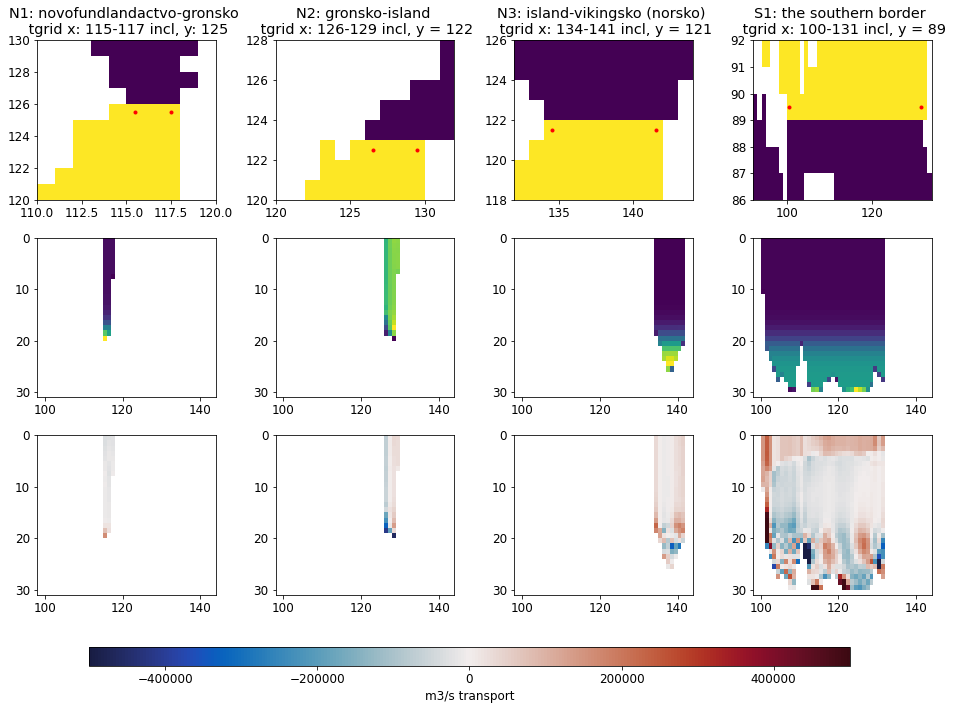

In [129]:
vgrid = xr.open_dataset(f'{tdir}ORCA2_1m_19600101_19601231_grid_V.nc')

fact = 1.1
fig, axs = plt.subplots(3,4, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].pcolormesh(tm)

axs[0].pcolormesh(tm)
axs[0].set_title('N1: novofundlandactvo-gronsko \n tgrid x: 115-117 incl, y: 125')
axs[0].pcolormesh(tm); axs[0].set_xlim([110,120]); axs[0].set_ylim([120,130])
axs[0].plot(115.5,125.5,'r.')
axs[0].plot(117.5,125.5,'r.')
#newfoundland boundary: x: 115,116,117 y:125

ind = 1
axs[ind].set_title('N2: gronsko-island \n tgrid x: 126-129 incl, y = 122')
axs[ind].pcolormesh(tm); axs[ind].set_xlim([120,132]); axs[ind].set_ylim([120,128])
axs[ind].plot(126.5,122.5,'r.');axs[ind].plot(129.5,122.5,'r.')
#gronsko boundary: x: 134-141 inclusive, y = 121

ind = 2
axs[ind].set_title('N3: island-vikingsko (norsko) \n tgrid x: 134-141 incl, y = 121')
axs[ind].pcolormesh(tm); axs[ind].set_xlim([132,144]); axs[ind].set_ylim([118,126])
axs[ind].plot(134.5,121.5,'r.');axs[ind].plot(141.5,121.5,'r.')
#gronsko boundary: x: 134-141 inclusive, y = 121

ind = 3
axs[ind].set_title('S1: the southern border \n tgrid x: 100-131 incl, y = 89')
axs[ind].pcolormesh(tm); axs[ind].set_xlim([92,134]); axs[ind].set_ylim([86,92])
axs[ind].plot(100.5,89.5,'r.');axs[ind].plot(131.5,89.5,'r.')

tvmi = -5e5
tvma = 5e5
y=125
axs[0+4].pcolormesh(csize_N1v)
axs[0+8].pcolormesh(csize_N1v*vgrid.vomecrty[0,:,y,:], cmap = cm.balance, vmin = tvmi, vmax = tvma)

y=122
axs[1+4].pcolormesh(csize_N2v*vgrid.vomecrty[0,:,y,:])
axs[1+8].pcolormesh(csize_N2v*vgrid.vomecrty[0,:,y,:], cmap = cm.balance, vmin = tvmi, vmax = tvma)

y=121
axs[2+4].pcolormesh(csize_N3v)
axs[2+8].pcolormesh(csize_N3v*vgrid.vomecrty[0,:,y,:], cmap = cm.balance, vmin = tvmi, vmax = tvma)

y=88
axs[3+4].pcolormesh(csize_S1v)
w = axs[3+8].pcolormesh(csize_S1v*vgrid.vomecrty[0,:,y,:], cmap = cm.balance, vmin = tvmi, vmax = tvma)


for i in range(4,12):
    
    axs[i].invert_yaxis()
    axs[i].set_xlim([98,144])
    
    
cbar_ax = fig.add_axes([0.1, -0.06, .8, .03]) #left, bottom, width, height
fig.colorbar(w, cax=cbar_ax, orientation="horizontal", label = 'm3/s transport')
plt.tight_layout()

1.619e+17


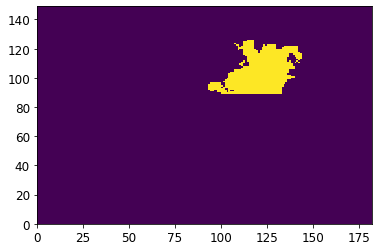

In [124]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')

masknoATLnb2 = np.copy(masknoATLnb)
masknoATLnb2[np.where(masknoATLnb>1)]=1
masknoATLnb2[np.where(masknoATLnb!=5)]=0
plt.pcolormesh(masknoATLnb2)


ATLbroad = np.zeros([31,149,182])
for i in range(0,31):
    ATLbroad[i,:,:] = masknoATLnb2 * tmesh.e1t[0,:,:].values * tmesh.e2t[0,:,:].values * tmesh.e3t_0[0,i,:,:].values
    
atlvol = (np.nansum(ATLbroad))
formatted_number = f"{atlvol:.3e}"
print(formatted_number)

-1.4107956122292549

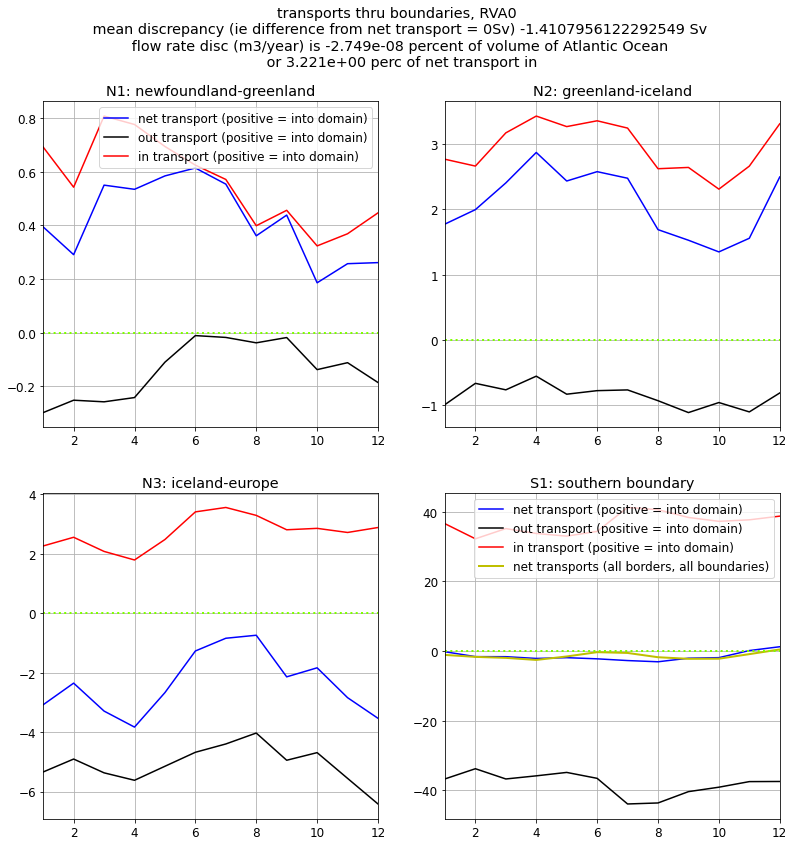

In [125]:
fact = 1.1


N1n = np.zeros([12,3])
N2n = np.zeros([12,3])
N3n = np.zeros([12,3])
S1n = np.zeros([12,3])
#positive is out of domain

for i in range(0,12):
    
    N1sv = (csize_N1v*vgrid.vomecrty[i,:,125,:].values)*-1 #positive is out of domain

    N2sv = (csize_N2v*vgrid.vomecrty[i,:,122,:].values)*-1 #positive is out of domain

    N3sv = (csize_N3v*vgrid.vomecrty[i,:,121,:].values)*-1 #positive is out of domain

    S1sv = (csize_S1v*vgrid.vomecrty[i,:,88,:].values)

    N1n[i,0] = np.nansum(N1sv)
    N1n[i,1] = np.nansum(N1sv[np.where(N1sv<0)])
    N1n[i,2] = np.nansum(N1sv[np.where(N1sv>=0)])
    
    N2n[i,0] = np.nansum(N2sv)
    N2n[i,1] = np.nansum(N2sv[np.where(N2sv<0)])
    N2n[i,2] = np.nansum(N2sv[np.where(N2sv>=0)])
    
    N3n[i,0] = np.nansum(N3sv)
    N3n[i,1] = np.nansum(N3sv[np.where(N3sv<0)])
    N3n[i,2] = np.nansum(N3sv[np.where(N3sv>=0)])
    
    S1n[i,0] = np.nansum(S1sv)
    S1n[i,1] = np.nansum(S1sv[np.where(S1sv<0)])
    S1n[i,2] = np.nansum(S1sv[np.where(S1sv>=0)])
    
mos = np.arange(1,13,1)
fig, axs = plt.subplots(2,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
axs[0].plot(mos,N1n[:,0]/1e6, 'b-', label ='net transport (positive = into domain)')
axs[0].plot(mos,N1n[:,1]/1e6, 'k-', label ='out transport (positive = into domain)')
axs[0].plot(mos,N1n[:,2]/1e6, 'r-', label ='in transport (positive = into domain)')

ind = 1
axs[ind].plot(mos,N2n[:,0]/1e6, 'b-', label ='net transport (positive = into domain)')
axs[ind].plot(mos,N2n[:,1]/1e6, 'k-', label ='out transport (positive = into domain)')
axs[ind].plot(mos,N2n[:,2]/1e6, 'r-', label ='int transport (positive = into domain)')

ind = 2
axs[ind].plot(mos,N3n[:,0]/1e6, 'b-', label ='net transport (positive = into domain)')
axs[ind].plot(mos,N3n[:,1]/1e6, 'k-', label ='out transport (positive = into domain)')
axs[ind].plot(mos,N3n[:,2]/1e6, 'r-', label ='int transport (positive = into domain)')

ind = 3
axs[ind].plot(mos,S1n[:,0]/1e6, 'b-', label ='net transport (positive = into domain)')
axs[ind].plot(mos,S1n[:,1]/1e6, 'k-', label ='out transport (positive = into domain)')
axs[ind].plot(mos,S1n[:,2]/1e6, 'r-', label ='in transport (positive = into domain)')

tots = S1n[:,0]/1e6 + N1n[:,0]/1e6 + N2n[:,0]/1e6 + N3n[:,0]/1e6
axs[3].plot(mos, tots, 'y-', linewidth = 2, label = 'net transports (all borders, all boundaries)')
disc = np.nanmean(tots)


siy = 60*60*24*365.25

axs[0].legend(loc = 'best')
axs[3].legend(loc = 'best')

axs[0].set_title('N1: newfoundland-greenland')
axs[1].set_title('N2: greenland-iceland')
axs[2].set_title('N3: iceland-europe')
axs[3].set_title('S1: southern boundary')

for i in range(0,4):
    axs[i].set_xlim([1,12])
    axs[i].grid([1,12])
    axs[i].axhline(y=0, linestyle = ':', color = 'chartreuse', linewidth = 2)
    
perc = disc*siy/atlvol*100
percf = f"{perc:.3e}"
disct = (np.nanmean(tots/((N1n[:,1]+N2n[:,1]+N3n[:,1]+S1n[:,1])/1e6))*100)
disctf = f"{disct:.3e}"

plt.suptitle(f'transports thru boundaries, RVA0 \n mean discrepancy (ie difference from net transport = 0Sv) {disc} Sv \n flow rate disc (m3/year) is {percf} percent of volume of Atlantic Ocean \n or {disctf} perc of net transport in')
np.nanmean(tots)

### calculating lateral transport timeseries


In [132]:
def make_yearlist(yrst, yrend, dtype, tr, bd = 'S1'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/transports/{tr}_{yrs[i]}_{dtype}_{bd}.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

ylist = xr.open_mfdataset(make_yearlist(1950, 2022, 'DIC', 'RVA0', bd = 'S1'))

In [142]:
RVA0_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_TJ_RVA0_1945-2022.nc')


In [143]:
RVA0_amoc

<xarray.Dataset>
Dimensions:  (TIME: 936)
Coordinates:
  * TIME     (TIME) datetime64[ns] 1945-01-16T12:00:00 ... 2022-12-16T12:00:00
Data variables:
    AMOC     (TIME) float64 ...
Attributes:
    made in:  AMOC-PLANKTOM/makeAMOC_modelts.ipynb

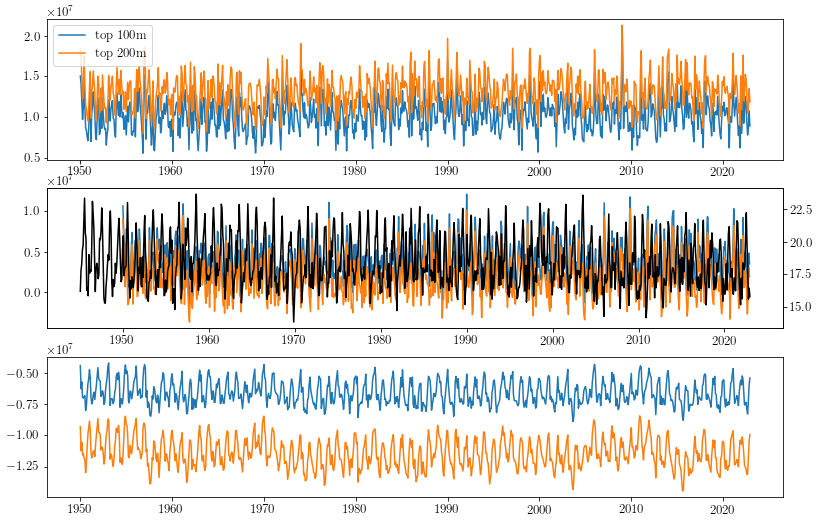

In [148]:
fact = 1.1
fig, axs = plt.subplots(3,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
#pos

axs[0].plot(ylist.time_counter,ylist['water_transports'][:,0,0], label = 'top 100m')
axs[0].plot(ylist.time_counter,ylist['water_transports'][:,1,0], label = 'top 200m')
axs[0].legend(loc = 'best')
axs0 = axs[1].twinx()
axs0.plot(RVA0_amoc.TIME,RVA0_amoc.AMOC, color = 'k')
#neg
axs[1].plot(ylist.time_counter,ylist['water_transports'][:,0,2])
axs[1].plot(ylist.time_counter,ylist['water_transports'][:,1,2])
#net
axs[2].plot(ylist.time_counter,ylist['water_transports'][:,0,1])
axs[2].plot(ylist.time_counter,ylist['water_transports'][:,1,1])

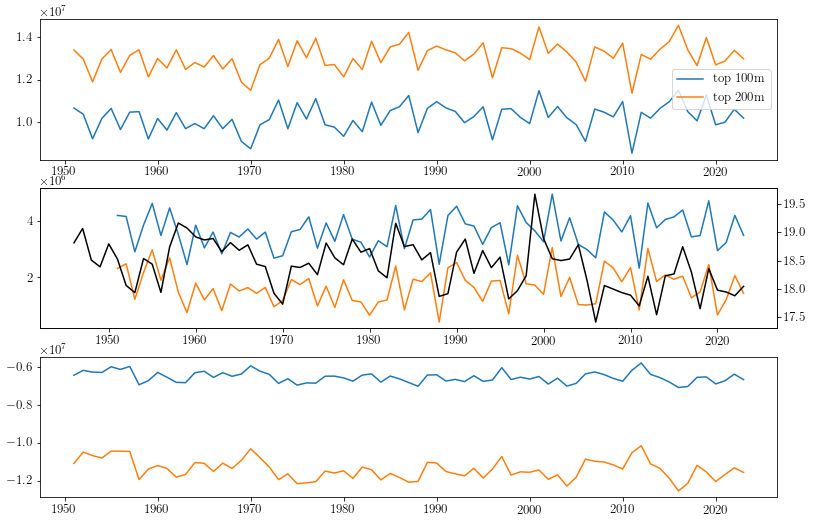

In [162]:
fact = 1.1
fig, axs = plt.subplots(3,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
#pos
yrly = ylist.resample(time_counter='Y').mean()


axs[0].plot(yrly.time_counter,yrly['water_transports'][:,0,0], label = 'top 100m')
axs[0].plot(yrly.time_counter,yrly['water_transports'][:,1,0], label = 'top 200m')
axs[0].legend(loc = 'best')

axs[1].plot(yrly.time_counter,yrly['water_transports'][:,0,2], label = 'top 100m')
axs[1].plot(yrly.time_counter,yrly['water_transports'][:,1,2], label = 'top 200m')
axs0 = axs[1].twinx()
RVA0y = RVA0_amoc.resample(TIME='Y').mean()
axs0.plot(RVA0y.TIME,RVA0y.AMOC, color = 'k')
# #neg
axs[2].plot(yrly.time_counter,yrly['water_transports'][:,0,1], label = 'top 100m')
axs[2].plot(yrly.time_counter,yrly['water_transports'][:,1,1], label = 'top 200m')


(73,)
(73,)
The Pearson correlation coefficient (r value) is: 0.16980475539356732
The Pearson correlation coefficient (r value) is: 0.04975516467418045


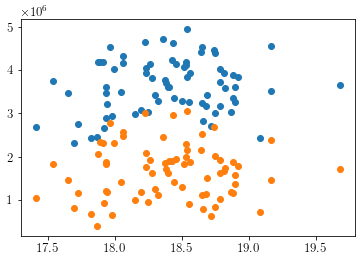

In [176]:
amoc = RVA0y.sel(TIME=slice('1950-01-01', '2022-12-31')).AMOC.values
net_t = yrly.sel(time_counter=slice('1950-01-01', '2022-12-31'))['water_transports'][:,0,2].values
net_t2 = yrly.sel(time_counter=slice('1950-01-01', '2022-12-31'))['water_transports'][:,1,2].values

print(np.shape(amoc))
print(np.shape(net_t))

plt.scatter(amoc, net_t, label = 'amoc vs c transport, 100m')
plt.scatter(amoc, net_t2, label = 'amoc vs c transport, 200m')


from scipy.stats import pearsonr

# Example data 
x = amoc #flxdiff[soy:-1]  # Replace with your actual data
y = net_t#c14diff[soy:-1]  # Replace with your actual data

r_value, p_value = pearsonr(x, y)

print(f"The Pearson correlation coefficient (r value) is: {r_value}")
# Calculate the Pearson correlation coefficient

# Example data 
x = amoc #flxdiff[soy:-1]  # Replace with your actual data
y = net_t2#c14diff[soy:-1]  # Replace with your actual data


r_value, p_value = pearsonr(x, y)
print(f"The Pearson correlation coefficient (r value) is: {r_value}")

In [154]:
yrly = ylist.groupby('time_counter.year').mean

In [156]:
yrly.values

AttributeError: 'function' object has no attribute 'values'